In [243]:
import IPython, numpy as np, scipy as sp, matplotlib.pyplot as plt, matplotlib, sklearn, librosa
from IPython.display import Audio
%matplotlib inline

import audio_utils
import vamp

import os

os.environ["VAMP_PATH"] = "./melodia_plugins/"

In [244]:
def melodic_frequency_filepath(filepath):
    audio, sr = librosa.load(filepath, mono=True)
    data = vamp.collect(audio, sr, "mtg-melodia:melodia")
    hop, melody = data['vector']
    return melody

def melodic_frequency(audio, sr):
    data = vamp.collect(audio, sr, "mtg-melodia:melodia")
    hop, melody = data['vector']
    return melody

In [245]:
# A clearer option is to get rid of the negative values before plotting
def plot_melody(melody):
    timestamps = 8 * 128/44100.0 + np.arange(len(melody)) * (128/44100.0)
    melody_pos = melody[:]
    melody_pos[melody<=0] = None
    plt.figure(figsize=(18,6))
    plt.plot(timestamps, melody_pos)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

In [246]:
VAMP_CONSTANT = (128/44100.0)

def timestamp_to_index(timestamp):
    index = (timestamp - (8 * VAMP_CONSTANT)) / VAMP_CONSTANT
    return int(index)

def find_interval_freq(start_time, end_time, melody):
    start_index = timestamp_to_index(start_time)
    end_index = timestamp_to_index(end_time)
    
    relevant_frequencies = melody[start_index:end_index]
    
    freq = find_freq(relevant_frequencies)
    
    return freq

def find_freq(melody):
    voiced_frequencies = np.array([ freq for freq in melody if freq > 0 ])
    freq = np.median(voiced_frequencies)
    return freq

In [247]:
def plot_and_play(y, sr, label=''):
    print(label)
    IPython.display.display(Audio(y, rate=sr))
    audio_utils.plot_audio(y, sr=sr)

In [347]:
from pydub import AudioSegment
import subprocess

SPEECH_FILEPATH = 'temp/tts_dump.wav'
TEXT_FILEPATH = 'temp/text.txt'
SCRIPT_FILEPATH = "./text_gen.sh"

# def tts(text):
#     """
#         returns list of AudioSegments corresponding to each word in text
#     """
#     tokens = text.split(' ')
    
#     audio_chunks = [tts_word(token) for token in tokens]

#     return audio_chunks

def tts_word(text, sr):

    with open(TEXT_FILEPATH, 'w+') as f:
        f.write(text)

    p = subprocess.call(SCRIPT_FILEPATH, shell=True)

    y = AudioSegment.from_wav(SPEECH_FILEPATH)

    x = y.set_frame_rate(sr)
    
    return x

In [499]:
from pydub.silence import split_on_silence

def get_syllable_signals(text, sr):
    params = {'min_silence_len': 40, 
              'silence_thresh': -18, 
              'keep_silence': 10
             }
    audio_words = tts_word(text, sr)
    audio_words = audio_words.set_frame_rate(sr)

    audio_chunks = split_on_silence(audio_words, 
                                    min_silence_len=params['min_silence_len'], 
                                    silence_thresh=params['silence_thresh'], 
                                    keep_silence=params['keep_silence'])

    all_segments = [np.array(chunk.get_array_of_samples(), dtype=float) for chunk in audio_chunks]

    return all_segments

In [349]:
def onset_intervals(y, sr):
    onset_times = librosa.onset.onset_detect(y=y, sr=sr, units='time')
    
    final_time = len(y)/ sr
    
    onset_intervals = [onset_interval(i, onset, onset_times, final_time) for i, onset in enumerate(onset_times)]
    
    return onset_intervals

def onset_interval(i, onset_start, onset_times, last_timestamp):
        if i+1 >= len(onset_times):
            return (onset_start, last_timestamp)
        
        else:
            return (onset_start, onset_times[i+1])
    
def onset_frequencies(y, sr):
    intervals = onset_intervals(y, sr)
    y_melody = melodic_frequency(y, sr)
    y_freqs = [find_interval_freq(start, end, y_melody) for start, end in intervals]
    return intervals, y_freqs

In [350]:
def pitch_difference(fn, f0):
    n_steps = np.round(np.log2(float(fn)/f0) * 12)
    return n_steps

In [351]:
def autotune(signals, fn, sr):
    
    shifted_signals = [pitch_correct(y=y, fn=f, sr=sr) for y, f in zip(signals, fn)]
    
    return shifted_signals

def pitch_correct(y, fn, sr):
    f0 = 150
    
    n_steps = pitch_difference(fn=fn, f0=f0)

    shifted_y = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)

    return shifted_y
    

In [352]:
def stretch_signals(signals, intervals, sr):
    stretchy = [stretch_signal(y=y, interval=interval, sr=sr) for y, interval in zip(signals, intervals)]
    return stretchy

def stretch_signal(y, interval, sr):
    
        note_duration = interval[1] - interval[0]
        y_duration = librosa.get_duration(y=y, sr=sr)
        rate = y_duration/note_duration
        stretched_y = librosa.effects.time_stretch(y, rate=rate)
        return stretched_y

In [353]:
def e2e(filename, text, sr):
    song, sr = librosa.load(filename, sr=sr)
    
    intervals, frequencies = onset_frequencies(song, sr)
    
    syllables = get_syllable_signals(text, sr)

    pitch_corrected_syllables = autotune(syllables, fn=frequencies, sr=sr)
    
    time_corrected_syllables = stretch_signals(pitch_corrected_syllables, intervals, sr=sr)
    
    tuned_voice_signal = np.concatenate(time_corrected_syllables)
    
    song_with_voice = overlay_signals(song, tuned_voice_signal, sr)
    
    return song_with_voice
    

In [354]:
def overlay_signals(song_signal, vocal_signal, sr):
    
    first_onset_sample = librosa.onset.onset_detect(y=song_signal, sr=sr, units='samples')[0]
    
    song_trimmed = song_signal[first_onset_sample:]

    min_length = min(len(song_trimmed), len(vocal_signal))
    
    both = librosa.util.normalize(song_trimmed[:min_length]) + librosa.util.normalize(vocal_signal[:min_length])
    
    return both

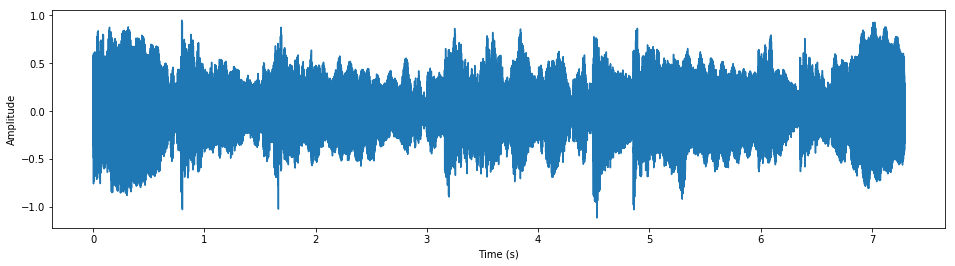

In [500]:
sr = 44100
text = 'miss congeniality was average'
y = e2e(filename='audio/hbd_snip.wav', text=text, sr=sr)
plot_and_play(y, sr)

In [356]:
import time

start = time.time()
syllables = get_syllable_signals('abdicate', sr=44100)
end = time.time()

one_word = end-start
print('one word', one_word)

word_count = 1000
one_trial = one_word * word_count
print('one trial', one_trial/60)

('one word', 0.15946698188781738)
('one trial', 2.657783031463623)


In [475]:
import yaml

def load_data(filename, n):
    with open(filename, 'r') as r:
        doc = yaml.load(r)
        step = len(doc)/n
        doc2 = doc[::step]
        words = np.array([obj['word'] for obj in doc2])
        counts = np.array([obj['count'] for obj in doc2])
        return words, counts

In [476]:
def write_data(filename, data):
    np.save(filename, data, allow_pickle=False)

In [477]:
from __future__ import print_function

def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end='\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

In [492]:
def run_experiment(signals, counts, silence_thresh, silence_len):

    records = np.zeros(shape=(silence_thresh.shape[0], silence_len.shape[0]))

    n_trials = len(silence_thresh)*len(silence_len)
    
    for i, st in enumerate(silence_thresh):
        for j, sl in enumerate(silence_len):
            results = run_trial(silence_thresh=st, silence_len=sl, signals=signals)
            accuracy = evaluate(results, counts)
            records[i,j] = accuracy
            current_trial = i*len(silence_len) + j + 1
            printProgressBar(current_trial, n_trials)
            
                   
    return records 

In [479]:
def syllable_count(silence_thresh, silence_len, signal):
    syllables = split_on_silence(signal, 
                                    min_silence_len=silence_len, 
                                    silence_thresh=silence_thresh)
    return len(syllables)

In [480]:
def run_trial(silence_thresh, silence_len, signals):
    
    counts = np.array([syllable_count(silence_thresh, silence_len, signal) for signal in signals])
    
    return counts

In [481]:
def evaluate(counts, answers):
    correct = np.sum(counts == answers)
    accuracy = float(correct) / len(answers)
    return accuracy

In [485]:
def plot_results(arr, silence_thresh, silence_len):
    plt.figure(figsize=(16,10))
    ax = plt.gca()
    ax.imshow(arr, cmap='hot', interpolation='nearest')

    ax.set_xticks(np.arange(arr.shape[1]))
    ax.set_yticks(np.arange(arr.shape[0]))

    ax.set_xticklabels(silence_len)
    ax.set_yticklabels(silence_thresh)
    plt.show()
# -15 -30
# 10 170

In [ ]:
words, counts = load_data('syllables/syllables-pruned.yaml', 500)
sr = 44100
signals = [tts_word(word, sr) for word in words]
silence_thresh = np.arange(
    start=-16, 
    stop=-22,
    step=-1)
# -10 to -50 
# best = -18
silence_len = np.arange(
    start=12, 
    stop=72,
    step=2)
# 0 to 400
# best = 100

results = run_experiment(signals, counts, silence_thresh, silence_len)
plot_results(results, silence_thresh, silence_len)
filename = 'syllables/results_' + str(silence_thresh[0]) + '_' +str(silence_thresh[-1]) + '_' + str(silence_len[0]) + '_'+str(silence_len[-1])
write_data(filename, results)


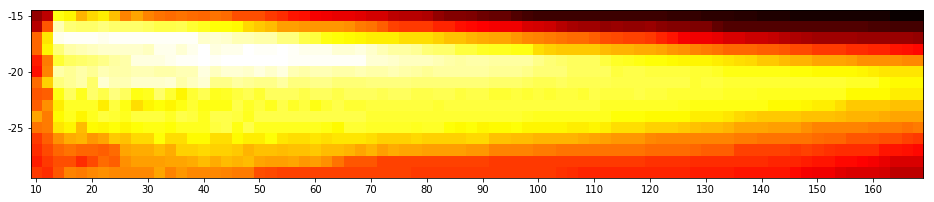

In [445]:
records = np.zeros(shape=(silence_thresh.shape[0], silence_len.shape[0]))

for i, st in enumerate(silence_thresh):
    for j, sl in enumerate(silence_len):
        result = results[i*len(silence_len)+j]['accuracy']
        records[i,j]=result
plot_results(records, silence_thresh, silence_len)

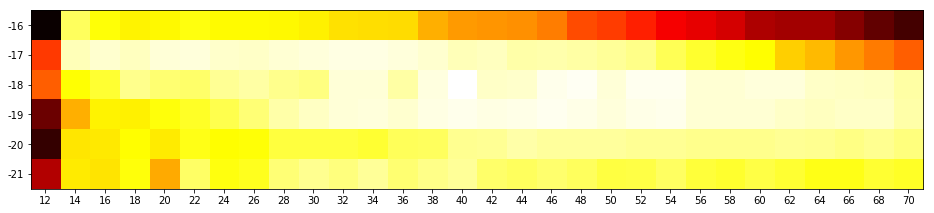

In [494]:
plot_results(results, silence_thresh, silence_len)

In [501]:
best = np.argwhere(results == np.amax(results))
best_indices = best.tolist()
best_combos = [(silence_thresh[st], silence_len[sl]) for st, sl in best_indices]
print('accuracy', np.amax(results))
for c in best_combos: print(c)

# {'silence_thresh': -18, 'silence_len': 40, 'accuracy': 0.9705882352941176}
# {'silence_thresh': -18, 'silence_len': 48, 'accuracy': 0.9705882352941176}
# {'silence_thresh': -18, 'silence_len': 54, 'accuracy': 0.9705882352941176}
# {'silence_thresh': -19, 'silence_len': 40, 'accuracy': 0.9705882352941176}
# {'silence_thresh': -19, 'silence_len': 44, 'accuracy': 0.9705882352941176}
# {'silence_thresh': -19, 'silence_len': 46, 'accuracy': 0.9705882352941176}
# {'silence_thresh': -19, 'silence_len': 48, 'accuracy': 0.9705882352941176}
# {'silence_thresh': -19, 'silence_len': 50, 'accuracy': 0.9705882352941176}
# {'silence_thresh': -19, 'silence_len': 52, 'accuracy': 0.9705882352941176}
# {'silence_thresh': -19, 'silence_len': 54, 'accuracy': 0.9705882352941176}


accuracy 0.9565217391304348
(-18, 40)
